# Import Required Libraries
Import the necessary libraries, including NumPy and nltk.

In [59]:
# Import Required Libraries

import numpy as np
import nltk
from nltk.corpus import brown

# Download the Brown corpus if not already downloaded
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Huy\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

# Load and Preprocess the Corpus
Load a real-world text corpus and preprocess it by removing stop words, punctuation, and performing other text cleaning steps.

In [60]:
# Load and Preprocess the Corpus

import string
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Load the Brown corpus
corpus = brown.sents()

# Preprocess the corpus
stop_words = set(stopwords.words('english'))
processed_corpus = []

for sentence in corpus:
    # Convert to lower case
    sentence = [word.lower() for word in sentence]
    # Remove punctuation
    sentence = [word.translate(str.maketrans('', '', string.punctuation)) for word in sentence]
    # Remove stop words
    sentence = [word for word in sentence if word not in stop_words]
    # Remove empty strings
    sentence = [word for word in sentence if word]
    processed_corpus.append(sentence)

# Display the first 5 processed sentences
processed_corpus[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Huy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['fulton',
  'county',
  'grand',
  'jury',
  'said',
  'friday',
  'investigation',
  'atlantas',
  'recent',
  'primary',
  'election',
  'produced',
  'evidence',
  'irregularities',
  'took',
  'place'],
 ['jury',
  'said',
  'termend',
  'presentments',
  'city',
  'executive',
  'committee',
  'overall',
  'charge',
  'election',
  'deserves',
  'praise',
  'thanks',
  'city',
  'atlanta',
  'manner',
  'election',
  'conducted'],
 ['septemberoctober',
  'term',
  'jury',
  'charged',
  'fulton',
  'superior',
  'court',
  'judge',
  'durwood',
  'pye',
  'investigate',
  'reports',
  'possible',
  'irregularities',
  'hardfought',
  'primary',
  'mayornominate',
  'ivan',
  'allen',
  'jr'],
 ['relative',
  'handful',
  'reports',
  'received',
  'jury',
  'said',
  'considering',
  'widespread',
  'interest',
  'election',
  'number',
  'voters',
  'size',
  'city'],
 ['jury',
  'said',
  'find',
  'many',
  'georgias',
  'registration',
  'election',
  'laws',
  'outmoded',
 

# Build Co-occurrence Matrix
Build a co-occurrence matrix from the preprocessed text corpus.

In [61]:
import numpy as np
from scipy.sparse import lil_matrix
from collections import defaultdict

def build_cooccurrence_matrix(corpus, window_size=4):
    # Create a set of all unique words in the corpus
    vocab = set([word for sentence in corpus for word in sentence])
    # Create a dictionary that maps each word to a unique index
    vocab = {word: idx for idx, word in enumerate(vocab)}
    vocab_size = len(vocab)
    # Initialize the co-occurrence matrix as a sparse matrix
    cooccurrence_matrix = lil_matrix((vocab_size, vocab_size), dtype=np.float64)

    # Populate the co-occurrence matrix
    for sentence in corpus:
        for i, word in enumerate(sentence):
            word_idx = vocab[word]
            start = max(0, i - window_size)
            end = min(len(sentence), i + window_size + 1)
            for j in range(start, end):
                if i != j:
                    context_word = sentence[j]
                    context_word_idx = vocab[context_word]
                    cooccurrence_matrix[word_idx, context_word_idx] += 1

    return cooccurrence_matrix, vocab

# Build the co-occurrence matrix
cooccurrence_matrix, vocab = build_cooccurrence_matrix(processed_corpus)
# Display the first 5x5 part of the co-occurrence matrix
cooccurrence_matrix[:5, :5].toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

# Train the GloVE Model
Implement the GloVE algorithm and train the model on the co-occurrence matrix.

In [62]:
# Train the GloVE Model
import numpy as np

class GloVe:
    def __init__(self, vocab_size, embedding_dim, x_max=100, alpha=0.75):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.x_max = x_max
        self.alpha = alpha
        self.W = np.random.rand(vocab_size, embedding_dim)
        self.W_tilde = np.random.rand(vocab_size, embedding_dim)
        self.b = np.random.rand(vocab_size)
        self.b_tilde = np.random.rand(vocab_size)
        self.gradsq_W = np.ones((vocab_size, embedding_dim))
        self.gradsq_W_tilde = np.ones((vocab_size, embedding_dim))
        self.gradsq_b = np.ones(vocab_size)
        self.gradsq_b_tilde = np.ones(vocab_size)

    def train(self, cooccurrence_matrix, epochs=10, learning_rate=0.05):  # Reduced epochs to 10
        for epoch in range(epochs):
            total_cost = 0
            for i in range(self.vocab_size):
                for j in range(self.vocab_size):
                    if cooccurrence_matrix[i, j] > 0:
                        weight = (cooccurrence_matrix[i, j] / self.x_max) ** self.alpha if cooccurrence_matrix[i, j] < self.x_max else 1
                        cost = (np.dot(self.W[i], self.W_tilde[j]) + self.b[i] + self.b_tilde[j] - np.log(cooccurrence_matrix[i, j])) ** 2
                        total_cost += 0.5 * weight * cost

                        grad_common = weight * (np.dot(self.W[i], self.W_tilde[j]) + self.b[i] + self.b_tilde[j] - np.log(cooccurrence_matrix[i, j]))
                        grad_W_i = grad_common * self.W_tilde[j]
                        grad_W_tilde_j = grad_common * self.W[i]
                        grad_b_i = grad_common
                        grad_b_tilde_j = grad_common

                        self.W[i] -= learning_rate * grad_W_i / np.sqrt(self.gradsq_W[i])
                        self.W_tilde[j] -= learning_rate * grad_W_tilde_j / np.sqrt(self.gradsq_W_tilde[j])
                        self.b[i] -= learning_rate * grad_b_i / np.sqrt(self.gradsq_b[i])
                        self.b_tilde[j] -= learning_rate * grad_b_tilde_j / np.sqrt(self.gradsq_b_tilde[j])

                        self.gradsq_W[i] += grad_W_i ** 2
                        self.gradsq_W_tilde[j] += grad_W_tilde_j ** 2
                        self.gradsq_b[i] += grad_b_i ** 2
                        self.gradsq_b_tilde[j] += grad_b_tilde_j ** 2

            print(f'Epoch: {epoch + 1}, Cost: {total_cost}')

# Initialize and train the GloVe model
embedding_dim = 50  # Reduced embedding dimension to 50
glove = GloVe(vocab_size=len(vocab), embedding_dim=embedding_dim)
glove.train(cooccurrence_matrix, epochs=10, learning_rate=0.05)

Epoch: 1, Cost: 1095514.6854216715
Epoch: 2, Cost: 293420.5828326012
Epoch: 3, Cost: 190824.7512285667
Epoch: 4, Cost: 142020.94992546452
Epoch: 5, Cost: 112924.70754506097
Epoch: 6, Cost: 93455.80942344412
Epoch: 7, Cost: 79477.57138869159
Epoch: 8, Cost: 68950.45786995113
Epoch: 9, Cost: 60742.01469359678
Epoch: 10, Cost: 54169.256977340345


# Evaluate the Model
Evaluate the trained GloVE model by finding similar words and visualizing word embeddings.

Words similar to 'government':
states: 3.747222188700243
af: 3.2111591086949978
per: 3.0405071957820913
united: 3.030209049096609
cent: 2.6798328361438424
federal: 2.6717433043621113
state: 2.5672713260586524
said: 2.4925894992050255
vocational: 2.4831710310797446
one: 2.4808977323647405


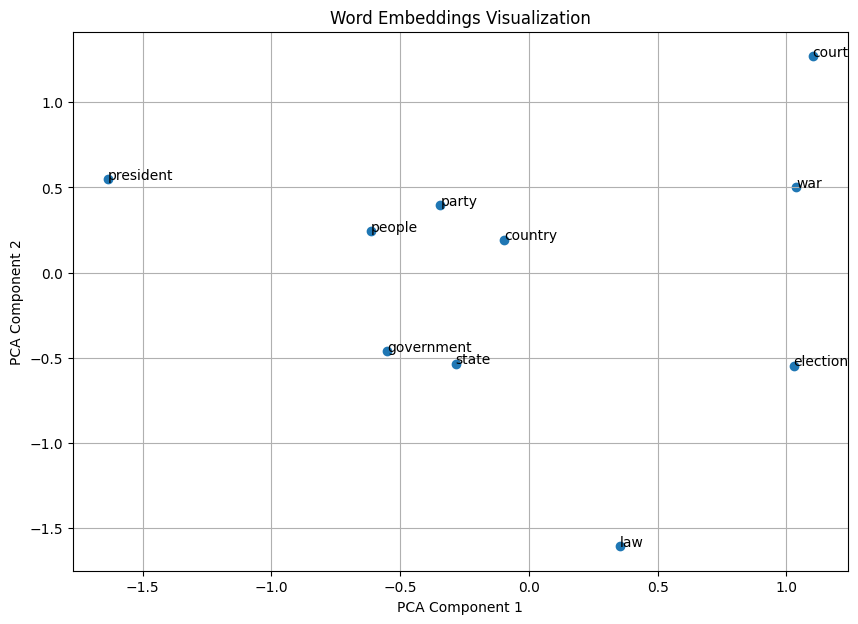

In [63]:
# Evaluate the Model

# Find similar words
def find_similar_words(word, vocab, embeddings, topn=10):
    if word not in vocab:
        return []
    word_idx = vocab[word]
    word_vector = embeddings[word_idx]
    similarities = np.dot(embeddings, word_vector)
    similar_indices = np.argsort(-similarities)[:topn + 1]
    similar_words = [(list(vocab.keys())[idx], similarities[idx]) for idx in similar_indices if idx != word_idx]
    return similar_words[:topn]

# Get the combined embeddings
combined_embeddings = glove.W + glove.W_tilde

# Find words similar to 'government'
similar_words = find_similar_words('government', vocab, combined_embeddings)
print("Words similar to 'government':")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

# Visualize word embeddings using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select a subset of words for visualization
words = ['government', 'country', 'president', 'people', 'state', 'war', 'law', 'court', 'party', 'election']
word_indices = [vocab[word] for word in words]
word_vectors = combined_embeddings[word_indices]

# Reduce dimensions using PCA
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Plot the word embeddings
plt.figure(figsize=(10, 7))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

plt.title('Word Embeddings Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [64]:
import json

# Save the embeddings
np.save('glove_embeddings.npy', combined_embeddings)

# Save the vocabulary
with open('glove_vocab.json', 'w') as f:
    json.dump(vocab, f)